# Логистическая регрессия в задаче классификации успеха маркетинговой кампании

Загрузим необходимые библиотеки

In [2]:
import numpy as np
import pandas as pd
import io
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer

## Логистическая регрессия

Несмотря на название, данный метод применяется именно в задачах классификации. Регрессия служит указанием на то, что мы пытаемся предсказать вероятность принадлежности классу. 

Метод основан на минимизации логистической функции потерь:

$$L(y_{true}, y_{predicted}) = \sum_{i=1}^n \ln (1 + e^{-y_{true} \cdot y_{predicted}}) \rightarrow \min_w,$$
где $y_{predicted}$ вычисляется по формуле $y_{predicted} = <w, x>$. Минимизация функции потерь происходит методом градиентного спуска.

In [4]:
from sklearn.linear_model import LogisticRegression

## Датасет

Возьмем датасет, содержащий информацию о клиентах и маркетинговой кампании некоторого банка. Наша задача $-$ предсказать успешность кампании для каждого клиента. Признаками являются различные характеристики клиента и кампании.

Для начала потребуется загрузить файл с данными bank-additional-full.csv , а затем, считать эти данные.

In [7]:
#Ваш код для загрузки БД
from google.colab import files 
uploaded = files.upload()

Saving bank-additional-full.csv to bank-additional-full.csv


In [8]:
# Считаем данные
data = pd.read_csv(io.BytesIO(uploaded['bank-additional-full.csv']), sep=';')

In [9]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [11]:
X = data.iloc[:, :-1].copy()
y = data.iloc[:, -1].copy()
y = LabelBinarizer().fit_transform(y).ravel()

Классы очень несбалансированы:

In [12]:
y.mean()

0.11265417111780131

Заметим, что среди признаков достаточно много категориальных, в то время как линейные модели работают с числовыми признаками.

Одним из способов получить числовые значения категориальных параметров является **one-hot encoding**. Его суть состоит в том, что для каждого категориального признака $f$ и каждого его значения $v$ создается новый признак, который равен 1 если у объекта значение $f$ равно $v$, и 0 $-$ иначе.

One-hot encoding с помощью pandas можно сделать одной строчкой:

In [13]:
X = pd.get_dummies(X)

# Обратите внимание на признаки
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 63 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   duration                       41188 non-null  int64  
 2   campaign                       41188 non-null  int64  
 3   pdays                          41188 non-null  int64  
 4   previous                       41188 non-null  int64  
 5   emp.var.rate                   41188 non-null  float64
 6   cons.price.idx                 41188 non-null  float64
 7   cons.conf.idx                  41188 non-null  float64
 8   euribor3m                      41188 non-null  float64
 9   nr.employed                    41188 non-null  float64
 10  job_admin.                     41188 non-null  uint8  
 11  job_blue-collar                41188 non-null  uint8  
 12  job_entrepreneur               41188 non-null 

Разобьем выборку на трейн и тест:

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Обучим линейный SVM с балансировкой классов:

In [15]:
from sklearn.svm import SVC

In [16]:
model_svm = SVC(kernel='linear', class_weight='balanced')
model_svm.fit(X_train, y_train)

y_pred = model_svm.predict(X_test)
print('Test accuracy: ', accuracy_score(y_test, y_pred))
print('Test F measure: ', f1_score(y_test, y_pred))

Test accuracy:  0.8829813061422676
Test F measure:  0.5630099728014506


Обучим логистическую регрессию. Из-за несбалансированности классов порог нужно выставлять в зависимости от целей кампании:

In [17]:
model_logistic = LogisticRegression()
model_logistic.fit(X_train, y_train)

y_predicted = model_logistic.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Построим график зависимости F-меры от порога положительного класса:

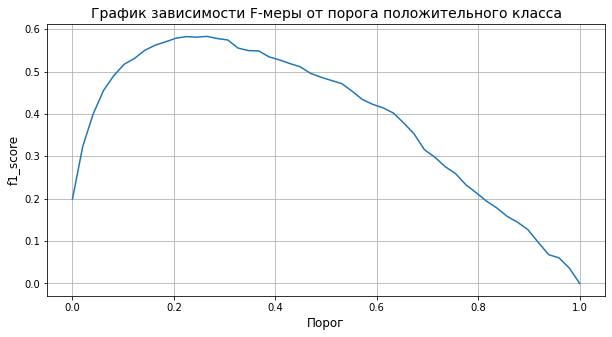

In [18]:
grid = np.linspace(0, 1, 50)
plt.figure(figsize=(10,5))
plt.title('График зависимости F-меры от порога положительного класса', fontsize=14)
plt.plot(grid, [f1_score(y_test, y_predicted > item) for item in grid])
plt.grid()
plt.xlabel('Порог', fontsize=12)
plt.ylabel('f1_score', fontsize=12);

In [19]:
print('Test accuracy: ', accuracy_score(y_test, y_predicted > 0.2))
print('Test F measure: ', f1_score(y_test, y_predicted > 0.2))
print('Test ROC-AUC: ', roc_auc_score(y_test, y_predicted))

Test accuracy:  0.8827385287691187
Test F measure:  0.5759438103599649
Test ROC-AUC:  0.9169557223130186
